In [6]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import timeit
import random

In [7]:
class yapay_sinir_agi():
    def __init__(self, katmanlar):
        self.katmanlar = katmanlar
        self.b = [np.random.randn(k, 1)/10 for k in self.katmanlar[1:]] # bias degerleri (ilk katman haric)
        self.W = [np.random.randn(k2, k1)/10 for k1, k2 in zip(self.katmanlar[:-1],self.katmanlar[1:])]
        self.H = [] # hata

    def ag(self):
        return self.W, self.b
    
    def ileribesleme(self, a):
        """Katman katman yeni a degerleri hesaplaniyor"""
        for w, b in zip(self.W, self.b):
            z = np.dot(w, a)+b
            a = self.sigmoid(z)
        return a
    
    def geribesleme(self,X,y):
        delta_b = [np.zeros(b.shape) for b in self.b]
        delta_w = [np.zeros(w.shape) for w in self.W]
        a = X; A, Z = [a], []  # A, Z degerleri
        for w, b in zip(self.W, self.b):# z ve a degerlerini depolayalim
            z = np.dot(w, a) + b
            a = self.sigmoid(z)
            Z.append(z); A.append(a)
           
        hata = A[-1] - y # En son katmandaki hata 
        delta = hata * self.sigmoid_turevi(Z[-1])
        delta_b[-1] = delta # Son katmanda W, b'deki degisim  
        delta_w[-1] = delta * A[-2].T # ERROR: np.dot(delta, A[-2].T)
        
        for k in range(2, len(self.katmanlar)): # Hatanin geriye yayilimi
            delta = np.dot(self.W[-k+1].T, delta) * self.sigmoid_turevi(Z[-k])
            delta_b[-k] = delta
            delta_w[-k] = delta * A[-k-1].T # ERROR: np.dot(delta, A[-k-1].T)
        return (delta_b, delta_w)  
    
    def hata(self,X,y):
        a = self.ileribesleme(X)
        return np.sum(np.power(a-y,2))
    
    
    def gradyan_inis(self, X_train, y_train, alpha, number_steps):
        for s in range(number_steps):
            i, m = 0,X_train.shape[1]
            X, y = X_train[:,[i]], y_train[:,[i]]
            tum_delta_b, tum_delta_w = self.geribesleme(X,y)
                
            for i in range(1,m): # Tum X kolonlari icin
                X, y = X_train[:,[i]], y_train[:,[i]]
                delta_b, delta_w = self.geribesleme(X,y)
                tum_delta_b = [tdb + db for tdb, db in zip(tum_delta_b, delta_b)]
                tum_delta_w = [tdw + dw for tdw, dw in zip(tum_delta_w, delta_w)]
                    
            tum_delta_b = [alpha*tdb for tdb in tum_delta_b]
            tum_delta_w = [alpha*tdw for tdw in tum_delta_w]
        
            self.W = [w - dw for w, dw in zip(self.W, tum_delta_w)]
            self.b = [b - db for b, db in zip(self.b, tum_delta_b)]
            self.H.append(self.hata(X,y))

    def fit(self, X_train, y_train, alpha = 0.05, number_steps = 1000):  
        X_train = X_train.T # X verileri kolon=gozlem, satir=oznitelik (alistigimizin tersi)
        if y_train.ndim == 1: y_train = y_train.reshape(1,y_train.shape[0])
        return self.gradyan_inis(X_train, y_train, alpha, number_steps)
    
    def predict(self, X_test):
        if self.katmanlar[-1] == 1 : 
            tahmin = ysa.ileribesleme(X_test.T) >= 0.5  
            t = tahmin.astype('int')
            return t[0]
        return np.argmax(ysa.ileribesleme(X_test.T), axis= 0)
    
    #### Yardimci Fonksiyonlar
    def sigmoid(self,z):
        return 1.0/(1.0+np.exp(-z))
    def sigmoid_turevi(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    def checkDimension(x):
        if x.ndim == 1: return x.reshape(x.shape[0], 1)
        return x

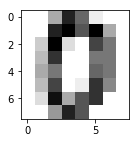

Etiket: 0
(360, 64)
(360,)
ogrenme kumesinin uzunlugu:  270
test kumesinin uzunlugu:  90
Time:  0.26531359797809273
					---SKlearn Multilayer Perceptron Network---
confusion_matrix:
 [[50  0]
 [ 0 40]]
accuracy_score:  1.0


In [12]:
#Rakamlar veri kümesini yüklüyoruz.
from sklearn.datasets import load_digits
#Veri kümesini etiket değerleriyle birlikte yükleyelim.
X,y = load_digits(return_X_y=True)

rakam1 = X[0]
rakam1 = np.reshape(rakam1, (8,8))

plt.figure(figsize= (2,2))
plt.imshow(rakam1, cmap="gray_r")
plt.show()
etiket1 = y[0]
print('Etiket: ' + str(etiket1))

# Bu veri kumesinden sadece 0 ve 1 rakamlarini secelim
X= X[y < 2]
y= y[y < 2]

print(X.shape)
print(y.shape)

#################################################
# Datayi train ve test olark ayir
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("ogrenme kumesinin uzunlugu: ", len(X_train))
print("test kumesinin uzunlugu: ", len(X_test))

#################################################
# Datayi normalize et 
#.      Standardize features by removing the mean and scaling to unit variance
#.      Centering and scaling happen independently on each feature
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#################################################
# yapay ogrenme
# Agin katmanlari 2 (girdi), 3(ara) , 1(cikti) 
    # SADECE ara katman degerlerini MLPClassifier'a veriyoruz
    # sigmoid icin activation= 'logistic' seciyoruz
from sklearn.neural_network import MLPClassifier
start_time = timeit.default_timer()
mlp = MLPClassifier(activation= 'logistic', hidden_layer_sizes=(3),max_iter=500)
mlp.fit(X_train,y_train)
#################################################
# tahminde bulun
y_pred = mlp.predict(X_test)
print("Time: ", timeit.default_timer() - start_time)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("\t\t\t\t\t---SKlearn Multilayer Perceptron Network---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, y_pred))

Time:  1.6398730920045637
					---Our Own Neural Network---
confusion_matrix:
 [[50  0]
 [ 0 40]]
accuracy_score:  1.0


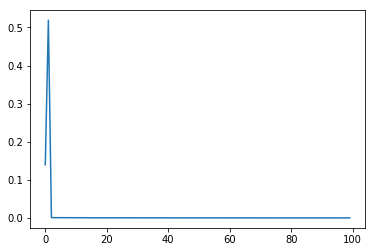

In [13]:
# Fitting Our Own Neural Network to the Training set
from sklearn.linear_model import LogisticRegression
start_time = timeit.default_timer()
ysa = yapay_sinir_agi(katmanlar = [64,6,1])
ysa.fit(X_train,y_train, alpha = 0.1, number_steps = 100)
tahmin = ysa.predict(X_test)
print("Time: ", timeit.default_timer() - start_time)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, tahmin)
print("\t\t\t\t\t---Our Own Neural Network---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, tahmin))
plt.plot(ysa.H)

In [14]:
#Rakamlar veri kümesini yüklüyoruz.
from sklearn.datasets import load_digits
#Veri kümesini etiket değerleriyle birlikte yükleyelim.
X,y = load_digits(return_X_y=True)

#################################################
# Datayi train ve test olark ayir
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("ogrenme kumesinin uzunlugu: ", len(X_train))
print("test kumesinin uzunlugu: ", len(X_test))

#################################################
# Datayi normalize et 
#.      Standardize features by removing the mean and scaling to unit variance
#.      Centering and scaling happen independently on each feature
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#################################################
# yapay ogrenme
# Agin katmanlari 2 (girdi), 3(ara) , 1(cikti) 
    # SADECE ara katman degerlerini MLPClassifier'a veriyoruz
    # sigmoid icin activation= 'logistic' seciyoruz
from sklearn.neural_network import MLPClassifier
start_time = timeit.default_timer()
mlp = MLPClassifier(activation= 'logistic', hidden_layer_sizes=(3),max_iter=500)
mlp.fit(X_train,y_train)
#################################################
# tahminde bulun
y_pred = mlp.predict(X_test)
print("Time: ", timeit.default_timer() - start_time)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("\t\t\t\t\t---SKlearn Multilayer Perceptron---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, y_pred))

ogrenme kumesinin uzunlugu:  1347
test kumesinin uzunlugu:  450
Time:  1.2541375750442967
					---SKlearn Multilayer Perceptron---
confusion_matrix:
 [[ 0  0  0  0  0  0 44  1  0  0]
 [ 0  9 28  1  0  0  0  0  9  0]
 [ 0  2 32  3  0  0  0  0  1  0]
 [ 0  0  0 48  0  2  0  0  0  0]
 [ 0  0  0  0  4  0 45  0  0  0]
 [ 0  0  1  2  0 38  0  1  2  1]
 [ 0  0  1  0  3  0 41  0  0  0]
 [ 0  0  0  2  0  1  1 37  0  1]
 [ 0  2  4  1  0 10  1  0 23  0]
 [ 0  0  0  4  0 38  0  2  2  2]]
accuracy_score:  0.52


In [ ]:
# Fitting Our Own Neural Network to the Training set
start_time = timeit.default_timer()
ysa = yapay_sinir_agi(katmanlar = [64,6,10])
ysa.fit(X_train,y_train, alpha = 0.9, number_steps = 100)

#zs = np.zeros((10,y_test.shape[0]))
#for c,r in enumerate(f): zs[r,c] = 1
    
#tahmin = [ysa.predict(zs[:,y].reshape(1,10)) for y in range(y_test.shape[0])]
tahmin = ysa.predict(X_test)
print("Time: ", timeit.default_timer() - start_time)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, tahmin)
print("\t\t\t\t\t---Our Own Neural Network---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, tahmin))
plt.plot(ysa.H)

In [ ]:
y_train.shape

In [ ]:
y_train

In [ ]:
y_pred

In [ ]:
ys = np.zeros((len(set(y_train)),len(y_train)))
for c,r in enumerate(y_train): ys[r,c] = 1

In [ ]:
zs.shape

In [ ]:
enumerate(f)

In [ ]:
zs[:,1].reshape(10,1)

In [ ]:
len(set(y_train)), len(y_train)

In [ ]:
zs[:,:13].shape

In [ ]:
y_train[:13]

In [ ]:
ysa.ileribesleme(X_train[1].reshape(64,1))

In [ ]:
X_train[0].shape

In [ ]:
def checkDimension(x):
    if x.ndim == 1: 
        return x.reshape(x.shape[0], 1)
    return x

In [ ]:
z = X_train[0]
print(z.shape)
z = checkDimension(z)
print(z.shape)

In [ ]:
z

In [ ]:
z.T.shape